# Data Cleaning

## Quick Overview

In [1]:
from timeit import default_timer as timer
import pandas as pd
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import time
from lightgbm import LGBMClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
%matplotlib inline
plt.rc('font', family='Times New Roman')
start_time = timer()

In [2]:
data = pd.read_csv('card transactions.csv')
data.head()

In [4]:
data.columns

Index(['Recnum', 'Cardnum', 'Date', 'Merchnum', 'Merch description',
       'Merch state', 'Merch zip', 'Transtype', 'Amount', 'Fraud'],
      dtype='object')

In [5]:
data.shape

(96753, 10)

In [6]:
data.dtypes

Recnum                 int64
Cardnum                int64
Date                  object
Merchnum              object
Merch description     object
Merch state           object
Merch zip            float64
Transtype             object
Amount               float64
Fraud                  int64
dtype: object

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Recnum             96753 non-null  int64  
 1   Cardnum            96753 non-null  int64  
 2   Date               96753 non-null  object 
 3   Merchnum           93378 non-null  object 
 4   Merch description  96753 non-null  object 
 5   Merch state        95558 non-null  object 
 6   Merch zip          92097 non-null  float64
 7   Transtype          96753 non-null  object 
 8   Amount             96753 non-null  float64
 9   Fraud              96753 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 7.4+ MB


## astype zip & Date

In [4]:
# zip
data['Merch zip'] = [
    str(round(i)).zfill(5) if pd.isnull(i) == False else i
    for i in data['Merch zip']
]

# Date
data['Date'] = pd.to_datetime(data.Date, format='%Y-%m-%d')
data['dow'] = data.Date.apply(lambda x: x.weekday())

# Cardnum
data['Cardnum'] = data['Cardnum'].astype(str)

# Replace 0 as nan
data['Merchnum'] = data.Merchnum.replace('0', np.nan, regex=False)

In [9]:
data.isnull().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum             3606
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
Fraud                   0
dow                     0
dtype: int64

## fill in na

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  object        
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93147 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  object        
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
 10  dow                96753 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 8.1+ MB


In [11]:
def cleaning(df, i, j):
    data = pd.DataFrame(df[df[j].notnull()], columns=[i, j])
    data = dict(data.groupby(i)[j].apply(lambda x: scipy.stats.mode(x)[0][0]))
    return data

### Merchnum

In [12]:
# fill in Merchnum
merchdes_merchnum = cleaning(data, 'Merch description', 'Merchnum')
for i in data[
        data['Merch description'].notnull()]['Merch description'].unique():
    if (i not in iter(merchdes_merchnum)):
        merchdes_merchnum[i] = 'unknown'

# fill in by mapping with Merch description
data['Merchnum'] = data['Merchnum'].fillna(
    data['Merch description'].map(merchdes_merchnum))

# '0' replaced as 'unknown'
data['Merchnum'] = data['Merchnum'].mask(data['Merchnum'] == '0', 'unknown')

# assign unknown for adjustments transactions
data['Merchnum'] = data['Merchnum'].mask(
    data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merchnum'] = data['Merchnum'].mask(
    data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

In [13]:
data.isnull().sum()

Recnum                  0
Cardnum                 0
Date                    0
Merchnum                0
Merch description       0
Merch state          1195
Merch zip            4656
Transtype               0
Amount                  0
Fraud                   0
dow                     0
dtype: int64

### Merch state

In [14]:
zip_state = cleaning(data, 'Merch zip', 'Merch state')

zip_state['00926'] = 'PR'
zip_state['00929'] = 'PR'
zip_state['00934'] = 'PR'
zip_state['00902'] = 'PR'
zip_state['00738'] = 'PR'
zip_state['90805'] = 'CA'
zip_state['76302'] = 'TX'
zip_state['00914'] = 'PR'
zip_state['95461'] = 'CA'
zip_state['00680'] = 'PR'
zip_state['00623'] = 'PR'
zip_state['00726'] = 'PR'
zip_state['00936'] = 'PR'
zip_state['12108'] = 'NY'
zip_state['00791'] = 'PR'
zip_state['00907'] = 'PR'
zip_state['00922'] = 'PR'
zip_state['00920'] = 'PR'
zip_state['00801'] = 'VI'
zip_state['31040'] = 'GA'
zip_state['41160'] = 'KY'
zip_state['00681'] = 'PR'

zip_state['86899'] = 'Foreign'
zip_state['23080'] = 'Foreign'
zip_state['48700'] = 'Foreign'
zip_state['50823'] = 'Foreign'

merchnum_state = cleaning(data, 'Merchnum', 'Merch state')

merchdes_state = cleaning(data, 'Merch description', 'Merch state')

# fill in by mapping with zip, merchnum and merch description
data['Merch state'] = data['Merch state'].fillna(
    data['Merch zip'].map(zip_state))
print(data['Merch state'].isnull().sum())
data['Merch state'] = data['Merch state'].fillna(
    data['Merchnum'].map(merchnum_state))
print(data['Merch state'].isnull().sum())
data['Merch state'] = data['Merch state'].fillna(
    data['Merch description'].map(merchdes_state))
print(data['Merch state'].isnull().sum())
# assign unknown for adjustments transactions
data['Merch state'] = data['Merch state'].mask(
    data['Merch description'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch state'] = data['Merch state'].mask(
    data['Merch description'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

1114
42
41


### zip

In [15]:
# fill in zip
merchnum_zip = cleaning(data, 'Merchnum', 'Merch zip')

merchdes_zip = cleaning(data, 'Merch description', 'Merch zip')

# fill in by mapping with merchnum and merch description
data['Merch zip'] = data['Merch zip'].fillna(
    data['Merchnum'].map(merchnum_zip))
print(data['Merch zip'].isnull().sum())
data['Merch zip'] = data['Merch zip'].fillna(
    data['Merch description'].map(merchdes_zip))
print(data['Merch zip'].isnull().sum())
# assign unknown for adjustments transactions
data['Merch zip'] = data['Merch zip'].mask(
    data['Merch zip'] == 'RETAIL CREDIT ADJUSTMENT', 'unknown')
data['Merch zip'] = data['Merch zip'].mask(
    data['Merch zip'] == 'RETAIL DEBIT ADJUSTMENT', 'unknown')

# fill the rest with unknown
data = data.fillna('unknown')
data.info()

1102
1074
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  object        
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           96753 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        96753 non-null  object        
 6   Merch zip          96753 non-null  object        
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
 10  dow                96753 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 8.1+ MB


## filter

### remove outlier

In [16]:
data.sort_values(['Amount'], ascending=False)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow
52714,52715,5142189135,2006-07-13,unknown,INTERMEXICO,MD,21045,P,3102045.53,0,3
47339,47340,5142275225,2006-06-22,unknown,INTERSOL,MD,21045,P,47900.00,0,3
59516,59517,5142138135,2006-08-03,900009045549,KRACKELER SCIENTIFIC,NY,12202,P,30372.46,1,3
80886,80887,5142152857,2006-10-11,unknown,CANYON ELECTRIC,NV,89102,P,28392.84,1,2
89673,89674,5142183210,2006-11-29,08-0980456333,CRUCIAL TECH./MICRON,ID,83642,P,27218.00,0,2
...,...,...,...,...,...,...,...,...,...,...,...
47165,47166,5142148452,2006-06-22,930009906224,FEDEX SHP 05/23/10 AB#,TN,38118,P,0.08,0,3
57855,57856,5142129787,2006-07-30,9108347680000,STAPLES NATIONAL #471,NJ,07606,P,0.02,0,6
78387,78388,5142236687,2006-09-28,9108233080006,STAPLES #990,CA,90640,P,0.01,0,3
91179,91180,5142239369,2006-12-06,89200648125,JOHN WILEY & SON SOMERSET,NJ,08875,P,0.01,0,2


In [17]:
data = data.drop([52714])
data.sort_values(['Amount'], ascending=False)

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow
47339,47340,5142275225,2006-06-22,unknown,INTERSOL,MD,21045,P,47900.00,0,3
59516,59517,5142138135,2006-08-03,900009045549,KRACKELER SCIENTIFIC,NY,12202,P,30372.46,1,3
80886,80887,5142152857,2006-10-11,unknown,CANYON ELECTRIC,NV,89102,P,28392.84,1,2
89673,89674,5142183210,2006-11-29,08-0980456333,CRUCIAL TECH./MICRON,ID,83642,P,27218.00,0,2
1103,1104,5142189945,2006-01-06,2036100687150,"GE REUTER-STOKES, INC",OH,44087,P,26910.00,0,4
...,...,...,...,...,...,...,...,...,...,...,...
47165,47166,5142148452,2006-06-22,930009906224,FEDEX SHP 05/23/10 AB#,TN,38118,P,0.08,0,3
57855,57856,5142129787,2006-07-30,9108347680000,STAPLES NATIONAL #471,NJ,07606,P,0.02,0,6
78387,78388,5142236687,2006-09-28,9108233080006,STAPLES #990,CA,90640,P,0.01,0,3
91179,91180,5142239369,2006-12-06,89200648125,JOHN WILEY & SON SOMERSET,NJ,08875,P,0.01,0,2


### filter transtype / only remain P

In [18]:
data = data[data['Transtype'] == 'P'].reset_index(drop=True)
data

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,6
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,6
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,6
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,6
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,6
...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2006-12-31,3500000006160,BEST BUY 00001610,KY,41042,P,84.79,0,6
96393,96750,5142225701,2006-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,P,118.75,0,6
96394,96751,5142226486,2006-12-31,4503057341100,"TECH PAC, INC",OH,45150,P,363.56,0,6
96395,96752,5142244619,2006-12-31,8834000695412,BUY.COM,CA,92656,P,2202.03,0,6


In [19]:
data.isna().sum()

Recnum               0
Cardnum              0
Date                 0
Merchnum             0
Merch description    0
Merch state          0
Merch zip            0
Transtype            0
Amount               0
Fraud                0
dow                  0
dtype: int64

## Risk table

In [20]:
train_test = data[data.Date < '2006-11-01']
# statistical smoothing
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_dow = train_test.groupby('dow')['Fraud'].mean()
num = train_test.groupby('dow').size()
y_dow_smooth = y_avg + (y_dow - y_avg) / (1 + np.exp(-(num - nmid) / c))
data['dow_risk'] = data.dow.map(y_dow_smooth)
y_dow = y_dow.reset_index()
cats = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]
y_dow['dow'] = pd.Categorical(y_dow['dow'], categories=cats, ordered=True)
y_dow = y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')
data['dow_risk'].value_counts()

0.007127    19588
0.008711    18517
0.009788    17943
0.009630    15033
0.010095    10176
0.018626    10055
0.025994     5085
Name: dow_risk, dtype: int64

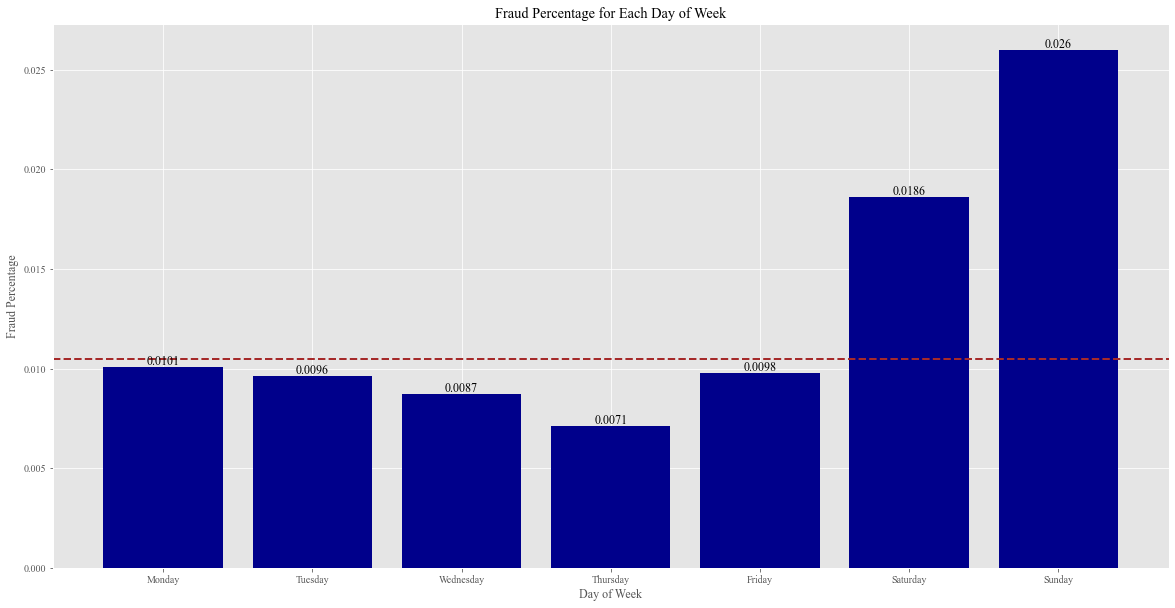

In [21]:
y_dow = y_dow.reset_index()
y_dow
cats = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
    'Sunday'
]
y_dow['dow'] = cats
# y_dow=y_dow.sort_values('dow')
y_dow = y_dow.set_index('dow')
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(data=y_dow, x=y_dow.index, height='Fraud', color='darkblue')
plt.title('Fraud Percentage for Each Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Fraud Percentage')
# ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg, ls='--', lw=2, color='brown')
for i, v in enumerate(y_dow.index):
    ax.text(v,
            y_dow.loc[v, 'Fraud'] + 0.0001,
            round(y_dow.loc[v, 'Fraud'], 4),
            horizontalalignment='center',
            fontsize=12)
plt.show()

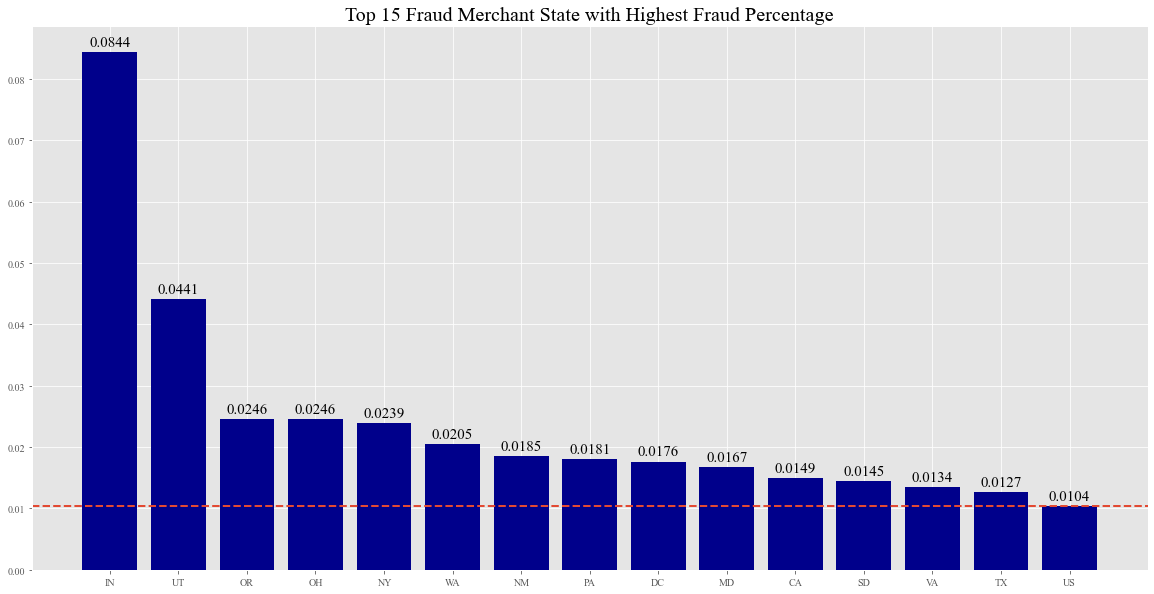

In [22]:
# statistical smoothing for creating staet target encoding (state_risk)
c = 4
nmid = 20
y_avg = train_test['Fraud'].mean()
y_state = train_test.groupby('Merch state')['Fraud'].mean()
num = train_test.groupby('Merch state').size()
# .size() is like counts.
y_state_smooth = y_avg + (y_state - y_avg) / (1 + np.exp(-(num - nmid) / c))
data['state_risk'] = data['Merch state'].map(y_state_smooth)
# It maps the value of the sereis "y_dow_smooth" by the corresponding indexes
# We need to renmae the y_state_smooth series since it is obtained from a formula calculation.
y_state_smooth = y_state_smooth.rename('Fraud')
y_state_smooth_top15 = y_state_smooth.sort_values(
    ascending=False).head(15).reset_index()
# The above code reset the index to 0-6, and pull out the column "dow"
cats_state_top15 = [
    i for i in y_state_smooth.sort_values(ascending=False).head(15).index
]
y_state_smooth_top15['Merch state'] = pd.Categorical(
    y_state_smooth_top15['Merch state'],
    categories=cats_state_top15,
    ordered=True)
# The code above set a new column 'Merch state' as a categories varaible, and set the order for
y_state_smooth_top15 = y_state_smooth_top15.set_index('Merch state')
import matplotlib.pyplot as plt

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(data=y_state_smooth_top15,
        x=y_state_smooth_top15.index,
        height='Fraud',
        color='darkblue')
# ax.set_ylim(bottom=0.013)
ax.axhline(y=y_avg, ls='--', lw=2)
ax.set_title('Top 15 Fraud Merchant State with Highest Fraud Percentage',
             fontsize=20)
# ax.text(xlocation,yloaction,text)
for i, v in enumerate(y_state_smooth_top15.index):
    ax.text(v,
            y_state_smooth_top15.loc[v, 'Fraud'] + 0.001,
            round(y_state_smooth_top15.loc[v, 'Fraud'], 4),
            horizontalalignment='center',
            fontsize=15)

In [23]:
train_test['Merch state'].unique()

array(['TN', 'MA', 'MD', 'OH', 'GA', 'IL', 'TX', 'WA', 'WI', 'NJ', 'FL',
       'NY', 'CA', 'MS', 'VA', 'MO', 'PA', 'NC', 'WV', 'CT', 'KS', 'OR',
       'SC', 'MI', 'MN', 'KY', 'ME', 'CO', 'DC', 'AK', 'IA', 'NH', 'MT',
       'OK', 'unknown', 'NV', 'RI', 'NE', 'AZ', 'NM', 'UT', 'ID', 'SD',
       'AL', 'DE', 'BC', 'LA', 'QC', 'IN', 'ON', 'VT', 'ND', 'PR', 'AR',
       'MB', 'HI', 'WY', 'Foreign', 'PQ', 'NS', 'AB', 'US', 'VI'],
      dtype=object)

In [24]:
data.head()

,Recnum,Cardnum,Date,Merchnum,Merch description,Merch state,Merch zip,Transtype,Amount,Fraud,dow,dow_risk,state_risk
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,6,0.025994,0.007970
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,P,31.42,0,6,0.025994,0.003304
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,P,178.49,0,6,0.025994,0.016694
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,P,3.62,0,6,0.025994,0.007970
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,P,3.62,0,6,0.025994,0.007970


## Fix some special values 
For the records which have neither state nor zip and cannot fillna by mapping back to Merch description.

In [25]:
v_rec = data.loc[(data['Merch state'] == 'unknown')
                 & (data['Merch zip'] == 'unknown')].Recnum
for i in v_rec:
    data.loc[data.Recnum == i, 'Merch state'] = -i
    data.loc[data.Recnum == i, 'Merch zip'] = -i
data['Merch state'] = data['Merch state'].astype(str)
data['Merch zip'] = data['Merch zip'].astype(str)

In [26]:
del merchdes_merchnum
del merchnum_state
del merchdes_zip
del merchnum_zip
del v_rec
del y_avg
del y_dow
del y_dow_smooth
del zip_state

# Create Variables

## Rename column name

In [27]:
data = data.rename(
    columns={
        'Recnum': 'recnum',
        'Cardnum': 'cardnum',
        'Date': 'date',
        'Merchnum': 'merchnum',
        'Merch description': 'description',
        'Merch state': 'state',
        'Merch zip': 'zip5',
        'Amount': 'amount'
    })

In [28]:
data = data.drop(['Transtype'], axis=1)

## Create new variable - 'country' ( There are four unique values: US, Canada, Foreign, unknown)

In [29]:
us_s = pd.read_excel('us_state.xlsx')
ca_s = pd.read_excel('canada_state.xlsx')

In [30]:
def country_(i):
    country = ''
    if i in list(us_s['STATE']):
        country = 'US'
    elif i in list(ca_s['STATE']):
        country = 'Canada'
    elif i == 'Foreign':
        country = 'Foreign'
    else:
        country = 'unknown'
    return country

In [31]:
data['country'] = data['state'].apply(lambda x: country_(x))

## Create candidate variables

In [32]:
data['state_zip5_country'] = data['state'] + data['zip5'] + data['country']
data['merchnum_country'] = data['merchnum'] + data['country']
data['description_country'] = data['description'] + data['country']
data['description_state_zip5_country'] = data['description'] + data[
    'state'] + data['zip5'] + data['country']
data['cardnum_merchnum'] = data['cardnum'].astype(
    str) + data['merchnum'].astype(str)

In [33]:
data.columns

Index(['recnum', 'cardnum', 'date', 'merchnum', 'description', 'state', 'zip5',
       'amount', 'Fraud', 'dow', 'dow_risk', 'state_risk', 'country',
       'state_zip5_country', 'merchnum_country', 'description_country',
       'description_state_zip5_country', 'cardnum_merchnum'],
      dtype='object')

In [34]:
for field in list(data.iloc[:, np.r_[4:6, 12:17]].columns):
    data['cardnum_' + field] = data.cardnum + data[field]
for field in list(data.iloc[:, np.r_[4:6, 13:17]].columns):
    data['merchnum_' + field] = data.merchnum + data[field]

In [35]:
data = data.drop(['merchnum_merchnum_country'], axis=1)

In [36]:
data.columns

Index(['recnum', 'cardnum', 'date', 'merchnum', 'description', 'state', 'zip5',
       'amount', 'Fraud', 'dow', 'dow_risk', 'state_risk', 'country',
       'state_zip5_country', 'merchnum_country', 'description_country',
       'description_state_zip5_country', 'cardnum_merchnum',
       'cardnum_description', 'cardnum_state', 'cardnum_country',
       'cardnum_state_zip5_country', 'cardnum_merchnum_country',
       'cardnum_description_country', 'cardnum_description_state_zip5_country',
       'merchnum_description', 'merchnum_state', 'merchnum_state_zip5_country',
       'merchnum_description_country',
       'merchnum_description_state_zip5_country'],
      dtype='object')

In [37]:
len(data.columns)

30

In [38]:
attributes = list(data.iloc[:, np.r_[1, 3, 13:18, 20, 21:30]].columns)
attributes

['cardnum',
 'merchnum',
 'state_zip5_country',
 'merchnum_country',
 'description_country',
 'description_state_zip5_country',
 'cardnum_merchnum',
 'cardnum_country',
 'cardnum_state_zip5_country',
 'cardnum_merchnum_country',
 'cardnum_description_country',
 'cardnum_description_state_zip5_country',
 'merchnum_description',
 'merchnum_state',
 'merchnum_state_zip5_country',
 'merchnum_description_country',
 'merchnum_description_state_zip5_country']

In [39]:
len(attributes)

17

In [40]:
attributes

['cardnum',
 'merchnum',
 'state_zip5_country',
 'merchnum_country',
 'description_country',
 'description_state_zip5_country',
 'cardnum_merchnum',
 'cardnum_country',
 'cardnum_state_zip5_country',
 'cardnum_merchnum_country',
 'cardnum_description_country',
 'cardnum_description_state_zip5_country',
 'merchnum_description',
 'merchnum_state',
 'merchnum_state_zip5_country',
 'merchnum_description_country',
 'merchnum_description_state_zip5_country']

In [41]:
df1 = data.copy()
final = data
df1['check_date'] = df1.date
df1['check_record'] = df1.recnum
final.shape

(96397, 30)

In [42]:
import timeit
from timeit import default_timer as timer

start = timeit.default_timer()
for entity in attributes:
    try:
        print('Run time for the last entity ----------------- {}s'.format(
            timeit.default_timer() - st))
    except:
        print('')
    st = timeit.default_timer()
    ## Day-since variables:
    df_l = df1[['recnum', 'date', entity]]
    df_r = df1[['check_record', 'check_date', entity, 'amount']]
    temp = pd.merge(df_l, df_r, left_on=entity, right_on=entity)
    temp1 = temp[temp.recnum > temp.check_record][['recnum','date','check_date']]\
                                                   .groupby('recnum')[['date', 'check_date']].last()
    mapper = (temp1.date - temp1.check_date).dt.days
    final[entity + '_day_since'] = final.recnum.map(mapper)
    final[entity + '_day_since'].fillna(
        (final.date - pd.to_datetime('2010-01-01')).dt.days, inplace=True)
    print('\n' + entity + '_day_since ---> Done')
    ## Frequency & Amount variables:
    for time in [0, 1, 3, 7, 14, 30]:
        temp2 = temp[(temp.check_date >= (temp.date - dt.timedelta(time))) &\
                       (temp.recnum >= temp.check_record)][['recnum', entity, 'amount']]
        col_name = entity + '_count_' + str(time)
        mapper2 = temp2.groupby('recnum')[entity].count()
        final[col_name] = final.recnum.map(mapper2)
        print(col_name + ' ---> Done')
        final[entity + '_avg_' + str(time)] = final.recnum.map(
            temp2.groupby('recnum')['amount'].mean())
        final[entity + '_max_' + str(time)] = final.recnum.map(
            temp2.groupby('recnum')['amount'].max())
        final[entity + '_med_' + str(time)] = final.recnum.map(
            temp2.groupby('recnum')['amount'].median())
        final[entity + '_total_' + str(time)] = final.recnum.map(
            temp2.groupby('recnum')['amount'].sum())
        final[entity + '_actual/avg_' +
              str(time)] = final['amount'] / final[entity + '_avg_' +
                                                   str(time)]
        final[entity + '_actual/max_' +
              str(time)] = final['amount'] / final[entity + '_max_' +
                                                   str(time)]
        final[entity + '_actual/med_' +
              str(time)] = final['amount'] / final[entity + '_med_' +
                                                   str(time)]
        final[entity + '_actual/toal_' +
              str(time)] = final['amount'] / final[entity + '_total_' +
                                                   str(time)]
        print(entity + ' amount variables over past ' + str(time) +
              ' ---> Done')

print('Total run time: {}mins'.format((timeit.default_timer() - start) / 60))



cardnum_day_since ---> Done
cardnum_count_0 ---> Done
cardnum amount variables over past 0 ---> Done
cardnum_count_1 ---> Done
cardnum amount variables over past 1 ---> Done
cardnum_count_3 ---> Done
cardnum amount variables over past 3 ---> Done
cardnum_count_7 ---> Done
cardnum amount variables over past 7 ---> Done
cardnum_count_14 ---> Done
cardnum amount variables over past 14 ---> Done
cardnum_count_30 ---> Done
cardnum amount variables over past 30 ---> Done
Run time for the last entity ----------------- 6.754133566s

merchnum_day_since ---> Done
merchnum_count_0 ---> Done
merchnum amount variables over past 0 ---> Done
merchnum_count_1 ---> Done
merchnum amount variables over past 1 ---> Done
merchnum_count_3 ---> Done
merchnum amount variables over past 3 ---> Done
merchnum_count_7 ---> Done
merchnum amount variables over past 7 ---> Done
merchnum_count_14 ---> Done
merchnum amount variables over past 14 ---> Done
merchnum_count_30 ---> Done
merchnum amount variables over pa

cardnum_description_state_zip5_country amount variables over past 30 ---> Done
Run time for the last entity ----------------- 1.1444598789999532s

merchnum_description_day_since ---> Done
merchnum_description_count_0 ---> Done
merchnum_description amount variables over past 0 ---> Done
merchnum_description_count_1 ---> Done
merchnum_description amount variables over past 1 ---> Done
merchnum_description_count_3 ---> Done
merchnum_description amount variables over past 3 ---> Done
merchnum_description_count_7 ---> Done
merchnum_description amount variables over past 7 ---> Done
merchnum_description_count_14 ---> Done
merchnum_description amount variables over past 14 ---> Done
merchnum_description_count_30 ---> Done
merchnum_description amount variables over past 30 ---> Done
Run time for the last entity ----------------- 6.379010680000022s

merchnum_state_day_since ---> Done
merchnum_state_count_0 ---> Done
merchnum_state amount variables over past 0 ---> Done
merchnum_state_count_1 --

In [43]:
start = timeit.default_timer()
# velocity change variables
for ent in attributes:
    for d in ['0', '1']:
        for dd in ['7', '14', '30']:
            final[ent + '_count_' + d + '_by_' + dd] =\
            final[ent + '_count_' + d]/(final[ent + '_count_' + dd])/float(dd)

print('run time: {}s'.format(timeit.default_timer() - start))

run time: 0.8332990490000043s


In [44]:
final.columns

Index(['recnum', 'cardnum', 'date', 'merchnum', 'description', 'state', 'zip5',
       'amount', 'Fraud', 'dow',
       ...
       'merchnum_description_country_count_0_by_30',
       'merchnum_description_country_count_1_by_7',
       'merchnum_description_country_count_1_by_14',
       'merchnum_description_country_count_1_by_30',
       'merchnum_description_state_zip5_country_count_0_by_7',
       'merchnum_description_state_zip5_country_count_0_by_14',
       'merchnum_description_state_zip5_country_count_0_by_30',
       'merchnum_description_state_zip5_country_count_1_by_7',
       'merchnum_description_state_zip5_country_count_1_by_14',
       'merchnum_description_state_zip5_country_count_1_by_30'],
      dtype='object', length=1067)

In [45]:
del temp

## Ben's Law Variables

In [46]:
def n_low(df):
    return ((df['amount'].str.extract(r"([1-9])") == '1') |
            (df['amount'].str.extract(r"([1-9])") == '2')).sum()

In [47]:
cleaned_data = data[data.description.str.match(r"[Ff][Ee][Dd][Ee][Xx]") ==
                    False].copy()
cleaned_data.amount = cleaned_data.amount.astype(str)
cleaned_data.head()

,recnum,cardnum,date,merchnum,description,state,zip5,amount,Fraud,dow,...,merchnum_description_country_count_0_by_30,merchnum_description_country_count_1_by_7,merchnum_description_country_count_1_by_14,merchnum_description_country_count_1_by_30,merchnum_description_state_zip5_country_count_0_by_7,merchnum_description_state_zip5_country_count_0_by_14,merchnum_description_state_zip5_country_count_0_by_30,merchnum_description_state_zip5_country_count_1_by_7,merchnum_description_state_zip5_country_count_1_by_14,merchnum_description_state_zip5_country_count_1_by_30
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,31.42,0,6,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,178.49,0,6,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
7,8,5142191182,2006-01-01,6098208200062,MIAMI COMPUTER SUPPLY,OH,45429,230.32,0,6,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
8,9,5142258629,2006-01-01,602608969534,FISHER SCI ATL,GA,30091,62.11,0,6,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333
13,14,5142124791,2006-01-01,5725000466504,CDW*GOVERNMENT INC,IL,60061,106.89,0,6,...,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333


In [48]:
cardnums = cleaned_data.groupby('cardnum').apply(n_low)
cardnums['n'] = cleaned_data.groupby('cardnum')['amount'].count()
cardnums['n_low'] = cleaned_data.groupby('cardnum').apply(n_low)
cardnums = cardnums[['n', 'n_low']]
cardnums['n_high'] = cardnums['n'] - cardnums['n_low']

In [49]:
cardnums['n_low'] = cardnums['n_low'].replace(0, 1)
cardnums['n_high'] = cardnums['n_high'].replace(0, 1)

In [50]:
cardnums['R'] = 1.096 * cardnums['n_low'] / cardnums['n_high']
cardnums['1/R'] = 1 / cardnums['R']
cardnums['U'] = cardnums[['R', '1/R']].max(axis=1)

In [51]:
import math

cardnums['t'] = (cardnums['n'] - 15) / 3
cardnums['U*'] = 1 + ((cardnums['U'] - 1) / (1 + math.e**-cardnums['t']))

In [52]:
cardnums.sort_values('U*', ascending=False)[0:40].to_csv('Top 40 Cardnum.csv')

In [53]:
merchnums = cleaned_data.groupby('merchnum').apply(n_low)
merchnums['n'] = cleaned_data.groupby('merchnum')['amount'].count()
merchnums['n_low'] = cleaned_data.groupby('merchnum').apply(n_low)
merchnums = merchnums[['n', 'n_low']]
merchnums['n_high'] = merchnums['n'] - merchnums['n_low']

In [54]:
merchnums['n_low'] = merchnums['n_low'].replace(0, 1)
merchnums['n_high'] = merchnums['n_high'].replace(0, 1)

In [55]:
merchnums['R'] = 1.096 * merchnums['n_low'] / merchnums['n_high']
merchnums['1/R'] = 1 / merchnums['R']
merchnums['U'] = merchnums[['R', '1/R']].max(axis=1)

In [56]:
import math

merchnums['t'] = (merchnums['n'] - 15) / 3
merchnums['U*'] = 1 + ((merchnums['U'] - 1) / (1 + math.e**-merchnums['t']))

In [57]:
merchnums.sort_values('U*',
                      ascending=False)[0:40].to_csv('Top 40 Merchnums.csv')

In [58]:
cardnums_Ustar = pd.DataFrame(cardnums, columns=['U*'])
cardnums_Ustar

,U*
cardnum,
5142110002,1.000894
5142110081,1.066041
5142110313,1.021440
5142110402,1.298955
5142110434,1.000894
...,...
5142310397,1.000894
5142310525,1.043299
5142310598,1.015441


In [59]:
merchnums_Ustar = pd.DataFrame(merchnums, columns=['U*'])
merchnums_Ustar

,U*
merchnum,
003100006NOT6,1.000894
004740006ABC6,1.000894
005590006PNB6,1.000894
014430619 14,1.000894
014938913 51,1.000894
...,...
DU49038320006,1.000894
JCPENNE9 CO,1.014835
PENNE9 CO #05,1.000894


In [60]:
final = final.merge(cardnums_Ustar,
                    how='left',
                    left_on='cardnum',
                    right_on=cardnums_Ustar.index)
final = final.rename(columns={'U*': 'U*_cardnum'})
final = final.merge(merchnums_Ustar,
                    how='left',
                    left_on='merchnum',
                    right_on=merchnums_Ustar.index)
final = final.rename(columns={'U*': 'U*_merchnum'})
final

,recnum,cardnum,date,merchnum,description,state,zip5,amount,Fraud,dow,...,merchnum_description_country_count_1_by_14,merchnum_description_country_count_1_by_30,merchnum_description_state_zip5_country_count_0_by_7,merchnum_description_state_zip5_country_count_0_by_14,merchnum_description_state_zip5_country_count_0_by_30,merchnum_description_state_zip5_country_count_1_by_7,merchnum_description_state_zip5_country_count_1_by_14,merchnum_description_state_zip5_country_count_1_by_30,U*_cardnum,U*_merchnum
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,31.42,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,178.49,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96392,96749,5142276053,2006-12-31,3500000006160,BEST BUY 00001610,KY,41042,84.79,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.002393,1.000894
96393,96750,5142225701,2006-12-31,8090710030950,MARKUS OFFICE SUPPLIES,OH,45248,118.75,0,6,...,0.014286,0.004762,0.142857,0.014286,0.004762,0.142857,0.014286,0.004762,1.137948,1.288057
96394,96751,5142226486,2006-12-31,4503057341100,"TECH PAC, INC",OH,45150,363.56,0,6,...,0.040816,0.006667,0.095238,0.040816,0.006667,0.095238,0.040816,0.006667,1.201338,1.106055
96395,96752,5142244619,2006-12-31,8834000695412,BUY.COM,CA,92656,2202.03,0,6,...,0.021978,0.002899,0.023810,0.005495,0.000725,0.095238,0.021978,0.002899,1.499767,1.029441


In [61]:
data = data.merge(cardnums_Ustar,
                  how='left',
                  left_on='cardnum',
                  right_on=cardnums_Ustar.index)
data = data.rename(columns={'U*': 'U*_cardnum'})
data = data.merge(merchnums_Ustar,
                  how='left',
                  left_on='merchnum',
                  right_on=merchnums_Ustar.index)
data = data.rename(columns={'U*': 'U*_merchnum'})
data.head()

,recnum,cardnum,date,merchnum,description,state,zip5,amount,Fraud,dow,...,merchnum_description_country_count_1_by_14,merchnum_description_country_count_1_by_30,merchnum_description_state_zip5_country_count_0_by_7,merchnum_description_state_zip5_country_count_0_by_14,merchnum_description_state_zip5_country_count_0_by_30,merchnum_description_state_zip5_country_count_1_by_7,merchnum_description_state_zip5_country_count_1_by_14,merchnum_description_state_zip5_country_count_1_by_30,U*_cardnum,U*_merchnum
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,31.42,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,178.49,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,NaN
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,NaN


In [62]:
final['U*_cardnum'].isna().sum()

72

In [63]:
final['U*_merchnum'].isna().sum()

11775

In [64]:
data[data['description'] == 'GRAINGER #973'].merchnum.unique()

array(['06-3666654612'], dtype=object)

In [65]:
data['U*_merchnum'] = data['U*_merchnum'].fillna(data['U*_merchnum'].mean())
data['U*_cardnum'] = data['U*_cardnum'].fillna(data['U*_cardnum'].mean())
data.head()

,recnum,cardnum,date,merchnum,description,state,zip5,amount,Fraud,dow,...,merchnum_description_country_count_1_by_14,merchnum_description_country_count_1_by_30,merchnum_description_state_zip5_country_count_0_by_7,merchnum_description_state_zip5_country_count_0_by_14,merchnum_description_state_zip5_country_count_0_by_30,merchnum_description_state_zip5_country_count_1_by_7,merchnum_description_state_zip5_country_count_1_by_14,merchnum_description_state_zip5_country_count_1_by_30,U*_cardnum,U*_merchnum
0,1,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,1.933194
1,2,5142183973,2006-01-01,61003026333,SERVICE MERCHANDISE #81,MA,01803,31.42,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.604857,1.000894
2,3,5142131721,2006-01-01,4503082993600,OFFICE DEPOT #191,MD,20706,178.49,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.368143,1.025818
3,4,5142148452,2006-01-01,5509006296254,FEDEX SHP 12/28/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,1.044105,1.933194
4,5,5142190439,2006-01-01,5509006296254,FEDEX SHP 12/23/09 AB#,TN,38118,3.62,0,6,...,0.071429,0.033333,0.142857,0.071429,0.033333,0.142857,0.071429,0.033333,2.178008,1.933194


In [ ]:
# data.to_csv('final_vars.csv')